Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt

Data Preparation

In [2]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])
ACC
# HeartR
# SleepL

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
981995,17642.967007,0.505249,0.425720,-0.748764
981996,17642.987576,0.508194,0.429138,-0.750717
981997,17643.006946,0.508179,0.427200,-0.747284
981998,17643.026865,0.505737,0.427673,-0.749741


In [3]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
# หา start_timedelta, end_timedelta
print("Acc start    : "  + str(ACC_min_date) + " | Acc end    : " + str(ACC_max_date))
print("HeartR start : "  + str(HeartR_min_date) + " | HeartR end : " + str(HeartR_max_date))
print("SleepL start : "  + str(SleepL_min_date) + "             | SleepL end : " + str(SleepL_max_date))

Acc start    : -124489.16105 | Acc end    : 17643.046417
HeartR start : -556410.36066 | HeartR end : 16980.47229
SleepL start : 0             | SleepL end : 16980


In [4]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_new = ACC[(ACC['timedelta'] > SleepL_min_date) & (ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta'] > SleepL_min_date) & (HeartR['timedelta'] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL['timedelta'] > SleepL_min_date) & (SleepL['timedelta'] < SleepL_max_date)]
ACC_new
# HeartR_new
# SleepL_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


In [5]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second, 
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index() 
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

# acc_X, acc_Y, acc_Z
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC_new2 = ACC_new2.loc[:,~ACC_new2.columns.duplicated()].copy()
ACC_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_6248\2152281988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [6]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_6248\2085734111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [7]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_6248\1766712162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))


,sleep
timedelta,
0 days 00:00:30,-1.0
0 days 00:00:31,-1.0
0 days 00:00:32,-1.0
0 days 00:00:33,-1.0
0 days 00:00:34,-1.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


Merge Data and Standardized data

In [8]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on = 'timedelta' )
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')
df


,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,NaN,NaN
1,0 days 00:00:01,-0.240757,0.873826,0.415446,NaN,NaN
2,0 days 00:00:02,-0.244620,0.883943,0.387026,NaN,NaN
3,0 days 00:00:03,-0.248036,0.902427,0.347812,NaN,NaN
4,0 days 00:00:04,-0.241778,0.912946,0.321502,NaN,NaN
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [9]:
# Fill NA
# Heart rate
# df.fillna() # using median()
hr_mean = df.heartrate.mean()
df.heartrate.fillna(hr_mean, inplace = True)
# Sleep Label
# df.fillna() # with 0
df.sleep.fillna(0, inplace = True)
# Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,80.886761,0.0
1,-0.240757,0.873826,0.415446,80.886761,0.0
2,-0.244620,0.883943,0.387026,80.886761,0.0
3,-0.248036,0.902427,0.347812,80.886761,0.0
4,-0.241778,0.912946,0.321502,80.886761,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.000000,0.0
16977,-0.441990,-0.525476,0.723410,76.000000,0.0
16978,-0.441581,-0.525116,0.724003,76.000000,0.0
16979,-0.442283,-0.525849,0.723265,76.000000,0.0


In [10]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns] # <= standardized data of df_feature
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.000000
1,-0.581456,2.995094,0.757746,0.000000
2,-0.591075,3.024668,0.722696,0.000000
3,-0.599581,3.078699,0.674335,0.000000
4,-0.583998,3.109450,0.641889,0.000000
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630391
16977,-1.082531,-1.095348,1.137542,-0.630391
16978,-1.081511,-1.094296,1.138273,-0.630391
16979,-1.083260,-1.096440,1.137363,-0.630391


(<AxesSubplot:>, <AxesSubplot:>)

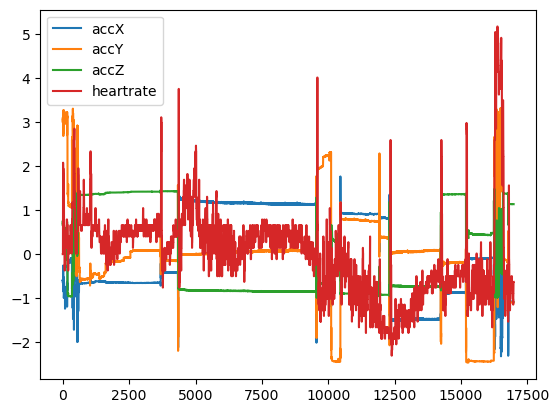

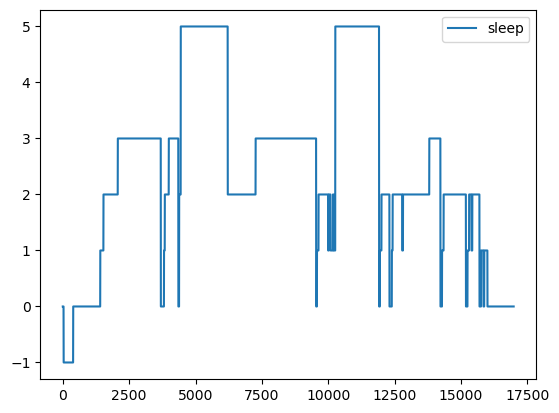

In [11]:
# Visualize signals
df_feature.plot(), df_label.plot()

Model Preparation (SVM)

In [12]:
# Train Test Split
x = df_feature
y = df_label
seed = 55
x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [13]:
# Model Traing Parameter
# Create SVC model
c_val = 100
gmm = 0.1
d = 2

In [14]:
# Model initialize
svc_lin = SVC(kernel='linear', C=c_val)
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree = d)

In [15]:
# Model Training
svc_rbf_pred = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)

c:\Users\napat\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\napat\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Model Testing (Predict)
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

SVM Prediction Report

In [17]:
# Model Confusion Matrix of SVC_rbf, SVC_poly

confusion_matrix(y_test,svc_rbf_pred)

array([[  87,    3,    0,    0,    0,    0],
       [   1,  549,    9,  136,   21,    7],
       [   0,   69,   60,  131,    4,   13],
       [   0,   40,    9, 1383,   73,   23],
       [   0,    0,    0,   50, 1336,    0],
       [   7,    1,    1,  181,    0,  901]], dtype=int64)

In [18]:
# Model Classification Report of SVC_rbf, SVC_poly

classification_report(y_test,svc_rbf_pred)

'              precision    recall  f1-score   support\n\n        -1.0       0.92      0.97      0.94        90\n         0.0       0.83      0.76      0.79       723\n         1.0       0.76      0.22      0.34       277\n         2.0       0.74      0.91      0.81      1528\n         3.0       0.93      0.96      0.95      1386\n         5.0       0.95      0.83      0.89      1091\n\n    accuracy                           0.85      5095\n   macro avg       0.85      0.77      0.79      5095\nweighted avg       0.85      0.85      0.84      5095\n'

HYPERPARAMETER TUNING(GRIDSEARCHCV())

In [19]:
#Create Model Parameter Dictionary for SVC
kernel = ['rbf', 'poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2, 3]
param_grid = dict(kernel=kernel, C = C_list, gamma = Gamma_list, degree = d_list )

In [20]:
# Perform GridsearchCV() for each classification model
grid = GridSearchCV( estimator = SVC(), n_jobs = 7, verbose = 10, scoring = 'accuracy', cv = 2, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits


In [ ]:
# Show best search results
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

In [ ]:
# Show Mean, std, params
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Display Mean, std, params

In [ ]:
score_df = pd.DataFrame(grid_result.cv_results_)
rbf_result = score_df[score_df['param_kernel'] == 'rbf']
rbf_param = [str(i) for i in rbf_result.params]
poly_result = score_df[score_df['param_kernel'] == 'poly']
poly_param = [str(i) for i in poly_result.params]

In [ ]:
# set width of bars
barWidth = 1
plt.figure(figsize=(50,30))
# Make the plot
plt.bar(rbf_param, rbf_result.mean_test_score, color='#7f6d5f', width=barWidth, edgecolor='white', label='svm rbf mean avg score') 
# Add xticks on the middle of the group bars
plt.xlabel('svm rbf mean avg score', fontweight='bold',fontsize=25)
plt.xticks(rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
# set width of bars
barWidth = 1 
plt.figure(figsize=(50,30))
# Make the plot
plt.bar(poly_param, poly_result.mean_test_score, color='#7f6d5f', width=barWidth, edgecolor='white', label='svm poly mean avg score') 
# Add xticks on the middle of the group bars
plt.xlabel('svm poly mean avg score', fontweight='bold',fontsize=20)
plt.xticks(rotation=90)
# Create legend & Show graphic
plt.legend()
plt.show()